# Convolutional Neural Networks (CNN) - MNIST Dataset


Neural networks have been presented already in other notebooks of this repository, and we have seen for multilayer perceptrons quite good accuracies for the datasets consisting of images (like MNIST). However, these networks present some limitations:

- They do not consider spatial information. The input is a flat vector reshaped as a matrix only in order to be plotted.
- No advantage of the modularity of the problem (it would not be able to classify a '2' in a digit like '23').
- The number of parameters can easily 'explode' when layers with many neurons are considered.

## 0. Loading the Dataset

First, we have to load the dataset like it has been done in other notebooks of this repository.

In [1]:
import time
import numpy as np
import scipy as sc
import sklearn as sk
import pandas  as pd
import seaborn as sns
sns.set_style("white")
import matplotlib.pyplot as plt
import numpy.random
from scipy.ndimage import shift
from scipy.ndimage import rotate
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils  import to_categorical

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input, Reshape, MaxPooling2D, BatchNormalization, Dropout, Conv2D, Dense, Flatten, Activation
from tensorflow.python.keras import backend as K

In [5]:
# Cargamos el dataset desde el archivo.
mnist = pd.read_csv("Datasets/MNIST.csv", header=None).values

# Guardamos las variables X e Y.
X, Y = mnist[:, 1:], mnist[:, 0:1]

# Normalizamos input y codificamos output con one-hot encoding.
Xt = X / 255.0
Yt = to_categorical(Y, 10)

## 1. Performing Data Augmentation

Now, over the normal data, we are going to perform Data Augmentation to generalize our train dataset as much as possible. We perform translations, rotations and we add a background noise up to different levals (if in doubt, please check the notebook [Data Augmentation on Images](https://github.com/LeviGuerra/Machine-Learning-Portfolio/blob/master/Codes_and_Datasets/09_Data-Augmentation_MNIST-Dataset.ipynb)).

In [6]:
def traslate_imgs(X):
  
  # Matriz resultado.
  trasl_X = np.zeros(X.shape)
  
  for ix, x in enumerate(X):
    
    # Convertimos a matriz el vector de píxeles.
    rx = x.reshape(28, 28)
    #r Seleccionamos cuánto vamos a cortar en X e Y.
    shift_x = np.random.randint(14) - 7
    shift_y = np.random.randint(14) - 7
    # Guardamos la traslación de la imagen.
    trasl_X[ix] = shift(x.reshape(28, 28), (shift_x, shift_y)).flatten()
    
  return trasl_X


def rotate_imgs(X):
  
  # Matriz resultado.
  rot_X = np.zeros(X.shape)
  
  for ix, x in enumerate(X):
    
    # Convertimos a matriz el vector de píxeles.
    rx = x.reshape(28, 28)
    # Seleccionamos el ángulo con el que rotar la imagen.
    angle = np.random.randint(180) - 90
    # Guardamos la traslación de la imagen.
    rot_X[ix] = rotate(x.reshape(28, 28), angle, reshape=False).flatten()
    
  return rot_X


def noise_imgs(X, noise_level=0.5):
  
  # Matriz resultado.
  nois_X = np.zeros(X.shape)
  
  for ix, x in enumerate(X):
    
    # Convertimos a matriz el vector de píxeles.
    rx = x.reshape(28, 28)
    # Seleccionamos el ángulo con el que rotar la imagen.
    noise = (np.random.random(x.shape) * 2.0  - 1) * noise_level
    # Guardamos la traslación de la imagen.
    nois_X[ix] = np.clip(x + noise, 0.0, 1.0).flatten()
    
  return nois_X

# Generamos train trasladada.
trasX_train = traslate_imgs(Xt)
# Generamos train rotada.
rotaX_train = rotate_imgs(Xt)
# Generamos train con ruido 50%.
no50X_train = noise_imgs(Xt, 0.5)
# Generamos train con ruido 25%.
no25X_train = noise_imgs(Xt, 0.25)

# Juntamos todos los sets.
augmX_train = np.vstack([Xt, 
                        trasX_train, 
                        rotaX_train, 
                        no50X_train, 
                        no25X_train])

# E incrementamos el vector Y por 5 veces.
augmY_train = np.tile(Yt, (5,1))

Visualization of how our augmented dataset is composed of distorted counterparts for each digit in the original dataset:

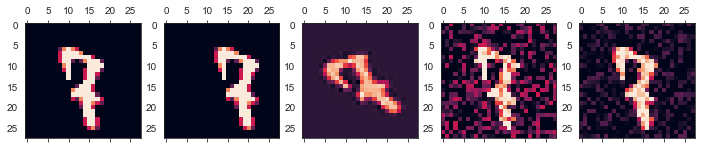

In [13]:
# Visualizamos los datos generados.
idx = 100

fig, axs = plt.subplots(1,5,figsize=(12,12))
axs[0].matshow(Xt[idx,:].reshape(28, 28))
axs[1].matshow(trasX_train[idx,:].reshape(28, 28))
axs[2].matshow(rotaX_train[idx,:].reshape(28, 28))
axs[3].matshow(no50X_train[idx,:].reshape(28, 28))
axs[4].matshow(no25X_train[idx,:].reshape(28, 28))
plt.show()

## 2. Training - Diferent Optimizers

Now that we have our augmented data, it is time to train our neural network. We split in train/test with a 70/30 ratio for two different optimizers. The best result obtained is **98.6%**. This accuracy is considerably higher than the one obtained with a simple fully connected network (check [this other notebook](http://localhost:8888/notebooks/GitHub%20Clones/ML18/Codes_and_Datasets/08_MLP_MNIST.ipynb)).

### 2.1 Adadelta Optimizer

In [6]:
start = time.time()

# Train/Test Split
X_train, X_test, Y_train, Y_test = train_test_split(augmX_train, augmY_train, train_size=0.7, test_size=0.3)

num_classes = 10

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

model1 = Sequential()

# Network Layers. Must define the input shape in the first layer of the neural network
model1.add(Conv2D(filters=64, kernel_size=8, padding='same'))
model1.add(Activation("relu"))
model1.add(BatchNormalization()) 
model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=128, kernel_size=4, padding='same'))
model1.add(Activation("relu"))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=256, kernel_size=2, padding='same'))
model1.add(Activation("relu"))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=2))

model1.add(Flatten())
model1.add(Dense(64, activation="relu"))
model1.add(Dropout(0.5))  
model1.add(Dense(32, activation="relu"))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes, activation="softmax"))

model1.compile(loss=tf.keras.losses.categorical_crossentropy,
             optimizer='adadelta',
             metrics=['accuracy'])

arr1 = model1.fit(X_train,
         Y_train,
         validation_data=(X_test,Y_test),
         batch_size=128,
         verbose=0,
         epochs=50)

score1 = model1.evaluate(X_test, Y_test, verbose=0)

print('Time spent to train the network:', round(time.time() - start,2), 'seconds\n')
print('Test loss:', score1[0])
print('Test accuracy:', score1[1],'\n')
model1.summary()

Time spent to train the network: 1097.42 seconds

Test loss: 0.14540924799854402
Test accuracy: 0.9785 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            multiple                  4160      
_________________________________________________________________
activation_3 (Activation)    multiple                  0         
_________________________________________________________________
batch_normalization_v1_3 (Ba multiple                  256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  131200    
_________________________________________________________________
activation_4 (Activation)    multiple                  0         
_____________________________________

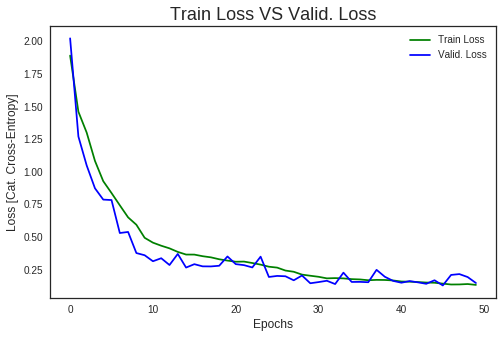

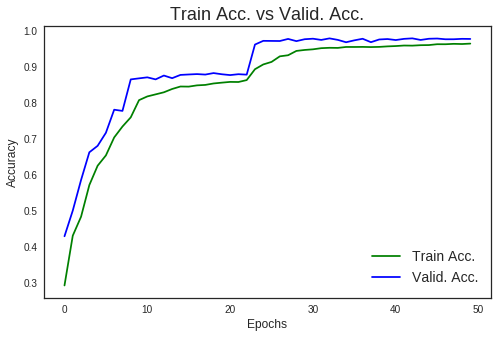

In [7]:
fig=plt.figure(figsize=(8,5))
plt.title("Train Loss VS Valid. Loss",fontsize=18)
plt.plot(arr1.history['loss'][:],     c="green")
plt.plot(arr1.history['val_loss'][:], c="blue" )
plt.legend(['Train Loss', 'Valid. Loss'])
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss [Cat. Cross-Entropy]',fontsize=12)
plt.show()

fig=plt.figure(figsize=(8,5))
plt.title("Train Acc. vs Valid. Acc.",fontsize=18)
plt.plot(arr1.history['acc'][:],     c="green")
plt.plot(arr1.history['val_acc'][:], c="blue" )
plt.legend(['Train Acc.', 'Valid. Acc.'],fontsize=14)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.show()

### 2.2 Adam Optimizer

In [8]:
start = time.time()

## Importamos Keras API
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input, Reshape, MaxPooling2D, BatchNormalization, Dropout, Conv2D, Dense, Flatten, Activation
from tensorflow.python.keras import backend as K

# Generamos train y test set.
X_train, X_test, Y_train, Y_test = train_test_split(augmX_train, augmY_train, train_size=0.7, test_size=0.3)

num_classes = 10

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


model2 = Sequential()

# Must define the input shape in the first layer of the neural network
model2.add(Conv2D(filters=64, kernel_size=8, padding='same')) 
model2.add(Activation("relu"))
model2.add(BatchNormalization()) 
model2.add(MaxPooling2D(pool_size=2))

model2.add(Conv2D(filters=128, kernel_size=4, padding='same'))
model2.add(Activation("relu"))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=2))

model2.add(Conv2D(filters=256, kernel_size=2, padding='same'))
model2.add(Activation("relu"))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=2))

model2.add(Flatten())
model2.add(Dense(64, activation="relu"))
model2.add(Dropout(0.5))  
model2.add(Dense(32, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation="softmax"))

model2.compile(loss=tf.keras.losses.categorical_crossentropy,
             optimizer='adam',
             metrics=['accuracy'])

arr2 = model2.fit(X_train,
         Y_train,
         validation_data=(X_test,Y_test),
         batch_size=128,
         verbose=0,
         epochs=50)

score2 = model2.evaluate(X_test, Y_test, verbose=0)

print('Time spent to train the network:', round(time.time() - start,2), 'seconds\n')
print('Test loss:', score2[0])
print('Test accuracy:', score2[1],'\n')
model2.summary()

Time spent to train the network: 1088.78 seconds

Test loss: 0.09870301600310098
Test accuracy: 0.9866667 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            multiple                  4160      
_________________________________________________________________
activation_6 (Activation)    multiple                  0         
_________________________________________________________________
batch_normalization_v1_6 (Ba multiple                  256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_7 (Conv2D)            multiple                  131200    
_________________________________________________________________
activation_7 (Activation)    multiple                  0         
__________________________________

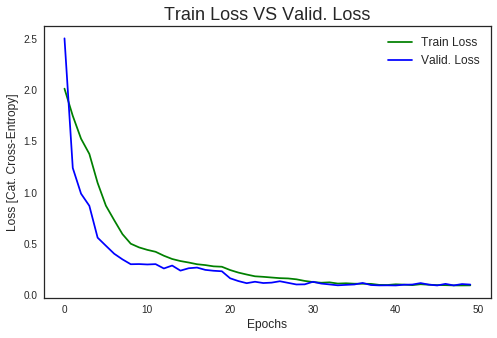

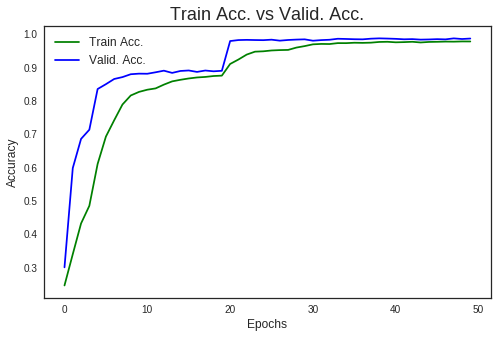

In [10]:
fig=plt.figure(figsize=(8,5))
plt.title("Train Loss VS Valid. Loss",fontsize=18)
plt.plot(arr2.history['loss'][:],     c="green")
plt.plot(arr2.history['val_loss'][:], c="blue" )
plt.legend(['Train Loss', 'Valid. Loss'],fontsize=12)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss [Cat. Cross-Entropy]',fontsize=12)
plt.show()

fig=plt.figure(figsize=(8,5))
plt.title("Train Acc. vs Valid. Acc.",fontsize=18)
plt.plot(arr2.history['acc'][:],     c="green")
plt.plot(arr2.history['val_acc'][:], c="blue" )
plt.legend(['Train Acc.', 'Valid. Acc.'],fontsize=12)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.show()